# part0: imports

In [2]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.WARNING)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.feature_selection import r_regression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import pyaldata as pyal


try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs
    
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
finally:
    os.chdir(nbPath)

n_components = min(monkey_defs.n_components, mouse_defs.n_components)

if "__file__" not in dir():
    reload(dt)
    reload(mouse_defs)
    reload(monkey_defs)
    print('Done!')

Done!


# reading data

In [3]:
def normal_mov(df, field:str ='hTrjB'):
    hTrjB = [pos + abs(np.nanmin(pos,axis=0)) for pos in df[field]]
    max_pos = np.array([np.nanmax(pos,axis=0) for pos in hTrjB])
    max_val = np.percentile(max_pos, 90, axis=0)
    hTrjB = [pos / max_val for pos in hTrjB]
    hTrjB = [pos - np.nanmean(pos, axis=0) for pos in hTrjB]
    df[field] = hTrjB
    return df

In [4]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = mouse_defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [5]:
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))
        
warnings.filterwarnings("default")

# Behavioural MSE

Monkeys

In [6]:
def within_monkey_MSE(allDF:list[pd.DataFrame], score = mean_squared_error, redo = False):
    defs = monkey_defs
    within_corrs = {}
    for df__ in allDF:
        within_corrs[df__.session[0]] = []
        pathPickle = root / 'monkey-pickles' / f'{df__.session[0]}_within_{score.__name__}.p'
        if os.path.exists(pathPickle) and not redo:
            with open(pathPickle,"rb") as f:
                result=pickle.load(f)
            within_corrs[df__.session[0]] = result
            continue
        else:
            df = pyal.restrict_to_interval(df__, epoch_fun=defs.exec_epoch)
            df = normal_mov(df,'pos')
            targets = np.unique(df.target_id)
            for target in targets:
                df_ = pyal.select_trials(df, df.target_id == target)
                for i, pos1 in enumerate(df_.pos):
                    a = pos1
                    for j, pos2 in enumerate(df_.pos):
                        if j<=i: continue
                        b = pos2
                        r = [float(score(aa.reshape(-1,1),bb)) for aa,bb in zip(a.T,b.T)]
                        within_corrs[df_.session[0]].append(np.mean(np.abs(r)))
        with open(pathPickle, 'wb') as f:
            pickle.dump(within_corrs[df_.session[0]], f)
            f.close()
    
    return within_corrs


def across_monkey_MSE(allDF:list[pd.DataFrame], score = mean_squared_error, redo=False):
    defs = monkey_defs
    across_corrs = {}
    for dfi, df1__ in enumerate(allDF):
        df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)
        df1 = normal_mov(df1,'pos')
        targets = np.unique(df1.target_id)
        across_corrs[df1.session[0]]={}
        for dfj, df2__ in enumerate(allDF):
            pathPickle = root / 'monkey-pickles' / f'{df1__.session[0]}_{df2__.session[0]}_across_{score.__name__}.p'
            if os.path.exists(pathPickle) and not redo:
                with open(pathPickle,"rb") as f:
                    result=pickle.load(f)
                across_corrs[df1__.session[0]][df2__.session[0]] = result
                across_corrs[df2__.session[0]] = {} if df2__.session[0] not in across_corrs.keys() else across_corrs[df2__.session[0]]
                continue
            df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
            df2 = normal_mov(df2,'pos')
            across_corrs[df2.session[0]] = {} if df2.session[0] not in across_corrs.keys() else across_corrs[df2.session[0]]
            if dfj <= dfi: continue
            across_corrs[df1.session[0]][df2.session[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, pos1 in enumerate(df1_.pos):
                    for j, pos2 in enumerate(df2_.pos):
                        r = [float(score(aa.reshape(-1,1),bb)) for aa,bb in zip(pos1.T,pos2.T)]
                        across_corrs[df1_.session[0]][df2_.session[0]].append(np.mean(np.abs(r)))
            
            with open(pathPickle, 'wb') as f:
                pickle.dump(across_corrs[df1_.session[0]][df2_.session[0]], f)
                f.close()

        # make the across correlations symmetrical!
        for  df2_session, val in across_corrs[df1__.session[0]].items():
            across_corrs[df2_session][df1__.session[0]] = val

    return across_corrs

Mice

In [7]:
def del_nan(a,b):
    a_bad = np.isnan(a)
    b_bad = np.isnan(b)
    bad = np.logical_or(a_bad,b_bad)
    good = np.logical_not(bad)
    
    return a[good].reshape(-1,1), b[good]

def within_mouse_MSE(allDF:list[pd.DataFrame], score = mean_squared_error):
    defs = mouse_defs
    trim_within_corrs = {}
    for df__ in allDF:
        df = pyal.restrict_to_interval(df__, epoch_fun=defs.exec_epoch)
        df = normal_mov(df)
        trim_within_corrs[df.file[0]] = []
        targets = np.unique(df.target_id)
        for target in targets:
            df_ = pyal.select_trials(df, df.target_id == target)
            for i, vel1 in enumerate(df_.hTrjB):
                for j, vel2 in enumerate(df_.hTrjB):
                    if j<=i: continue
                    r = [float(score(*del_nan(aa,bb))) for aa,bb in zip(vel1.T,vel2.T)]
                    trim_within_corrs[df_.file[0]].append(np.mean(np.abs(r)))

    return trim_within_corrs


def across_mouse_MSE(allDF:list[pd.DataFrame], score = mean_squared_error):
    defs = mouse_defs
    trim_across_corrs = {}
    across_good = across_bad = 0
    for dfi, df1__ in enumerate(allDF):
        df1 = pyal.restrict_to_interval(df1__, epoch_fun=defs.exec_epoch)
        df1 = normal_mov(df1)
        targets = np.unique(df1.target_id)
        trim_across_corrs[df1.file[0]]={}
        for dfj, df2__ in enumerate(allDF):
            df2 = pyal.restrict_to_interval(df2__, epoch_fun=defs.exec_epoch)
            df2 = normal_mov(df2)
            trim_across_corrs[df2.file[0]] = {} if df2.file[0] not in trim_across_corrs.keys() else trim_across_corrs[df2.file[0]]
            if dfj <= dfi: continue
            trim_across_corrs[df1.file[0]][df2.file[0]]=[]
            for target in targets:
                df1_ = pyal.select_trials(df1, df1.target_id == target)
                df2_ = pyal.select_trials(df2, df2.target_id == target)
                for i, vel1 in enumerate(df1_.hTrjB):
                    for j, vel2 in enumerate(df2_.hTrjB):
                        r = [float(score(*del_nan(aa,bb))) for aa,bb in zip(vel1.T,vel2.T)]
                        trim_across_corrs[df1_.file[0]][df2_.file[0]].append(np.mean(np.abs(r)))
                        across_good += 1

        # make the across correlations symmetrical!
        for  df2_file, val in trim_across_corrs[df1_.file[0]].items():
            trim_across_corrs[df2_file][df1_.file[0]] = val

    return trim_across_corrs

Calculate the correlations

In [18]:
if "__file__" not in dir():
    within_corrs_mice = within_mouse_MSE (AllDFs,)
    across_corrs_mice = across_mouse_MSE (AllDFs,)
      
    within_corrs_monkeys = within_monkey_MSE (allDFs_MCx, redo=False)
    across_corrs_monkeys = across_monkey_MSE (allDFs_MCx, redo=True) #TODO: `redo` has to be True!

    clear_output()

Plot scatter plot of all within and across correlations

In [21]:
monkey_w = []
monkey_a = []

for session1, session_list in across_corrs_monkeys.items():
    for session2, vals in session_list.items():
        monkey_w.append(np.mean(within_corrs_monkeys[session1]))
        monkey_w.append(np.mean(within_corrs_monkeys[session2]))
        monkey_a.extend([np.mean(vals),np.mean(vals)])


mouse_w = []
mouse_a = []

for session1, session_list in across_corrs_mice.items():
    for session2, vals in session_list.items():
        mouse_w.append(np.mean(within_corrs_mice[session1]))
        mouse_w.append(np.mean(within_corrs_mice[session2]))
        mouse_a.extend([np.mean(vals),np.mean(vals)])


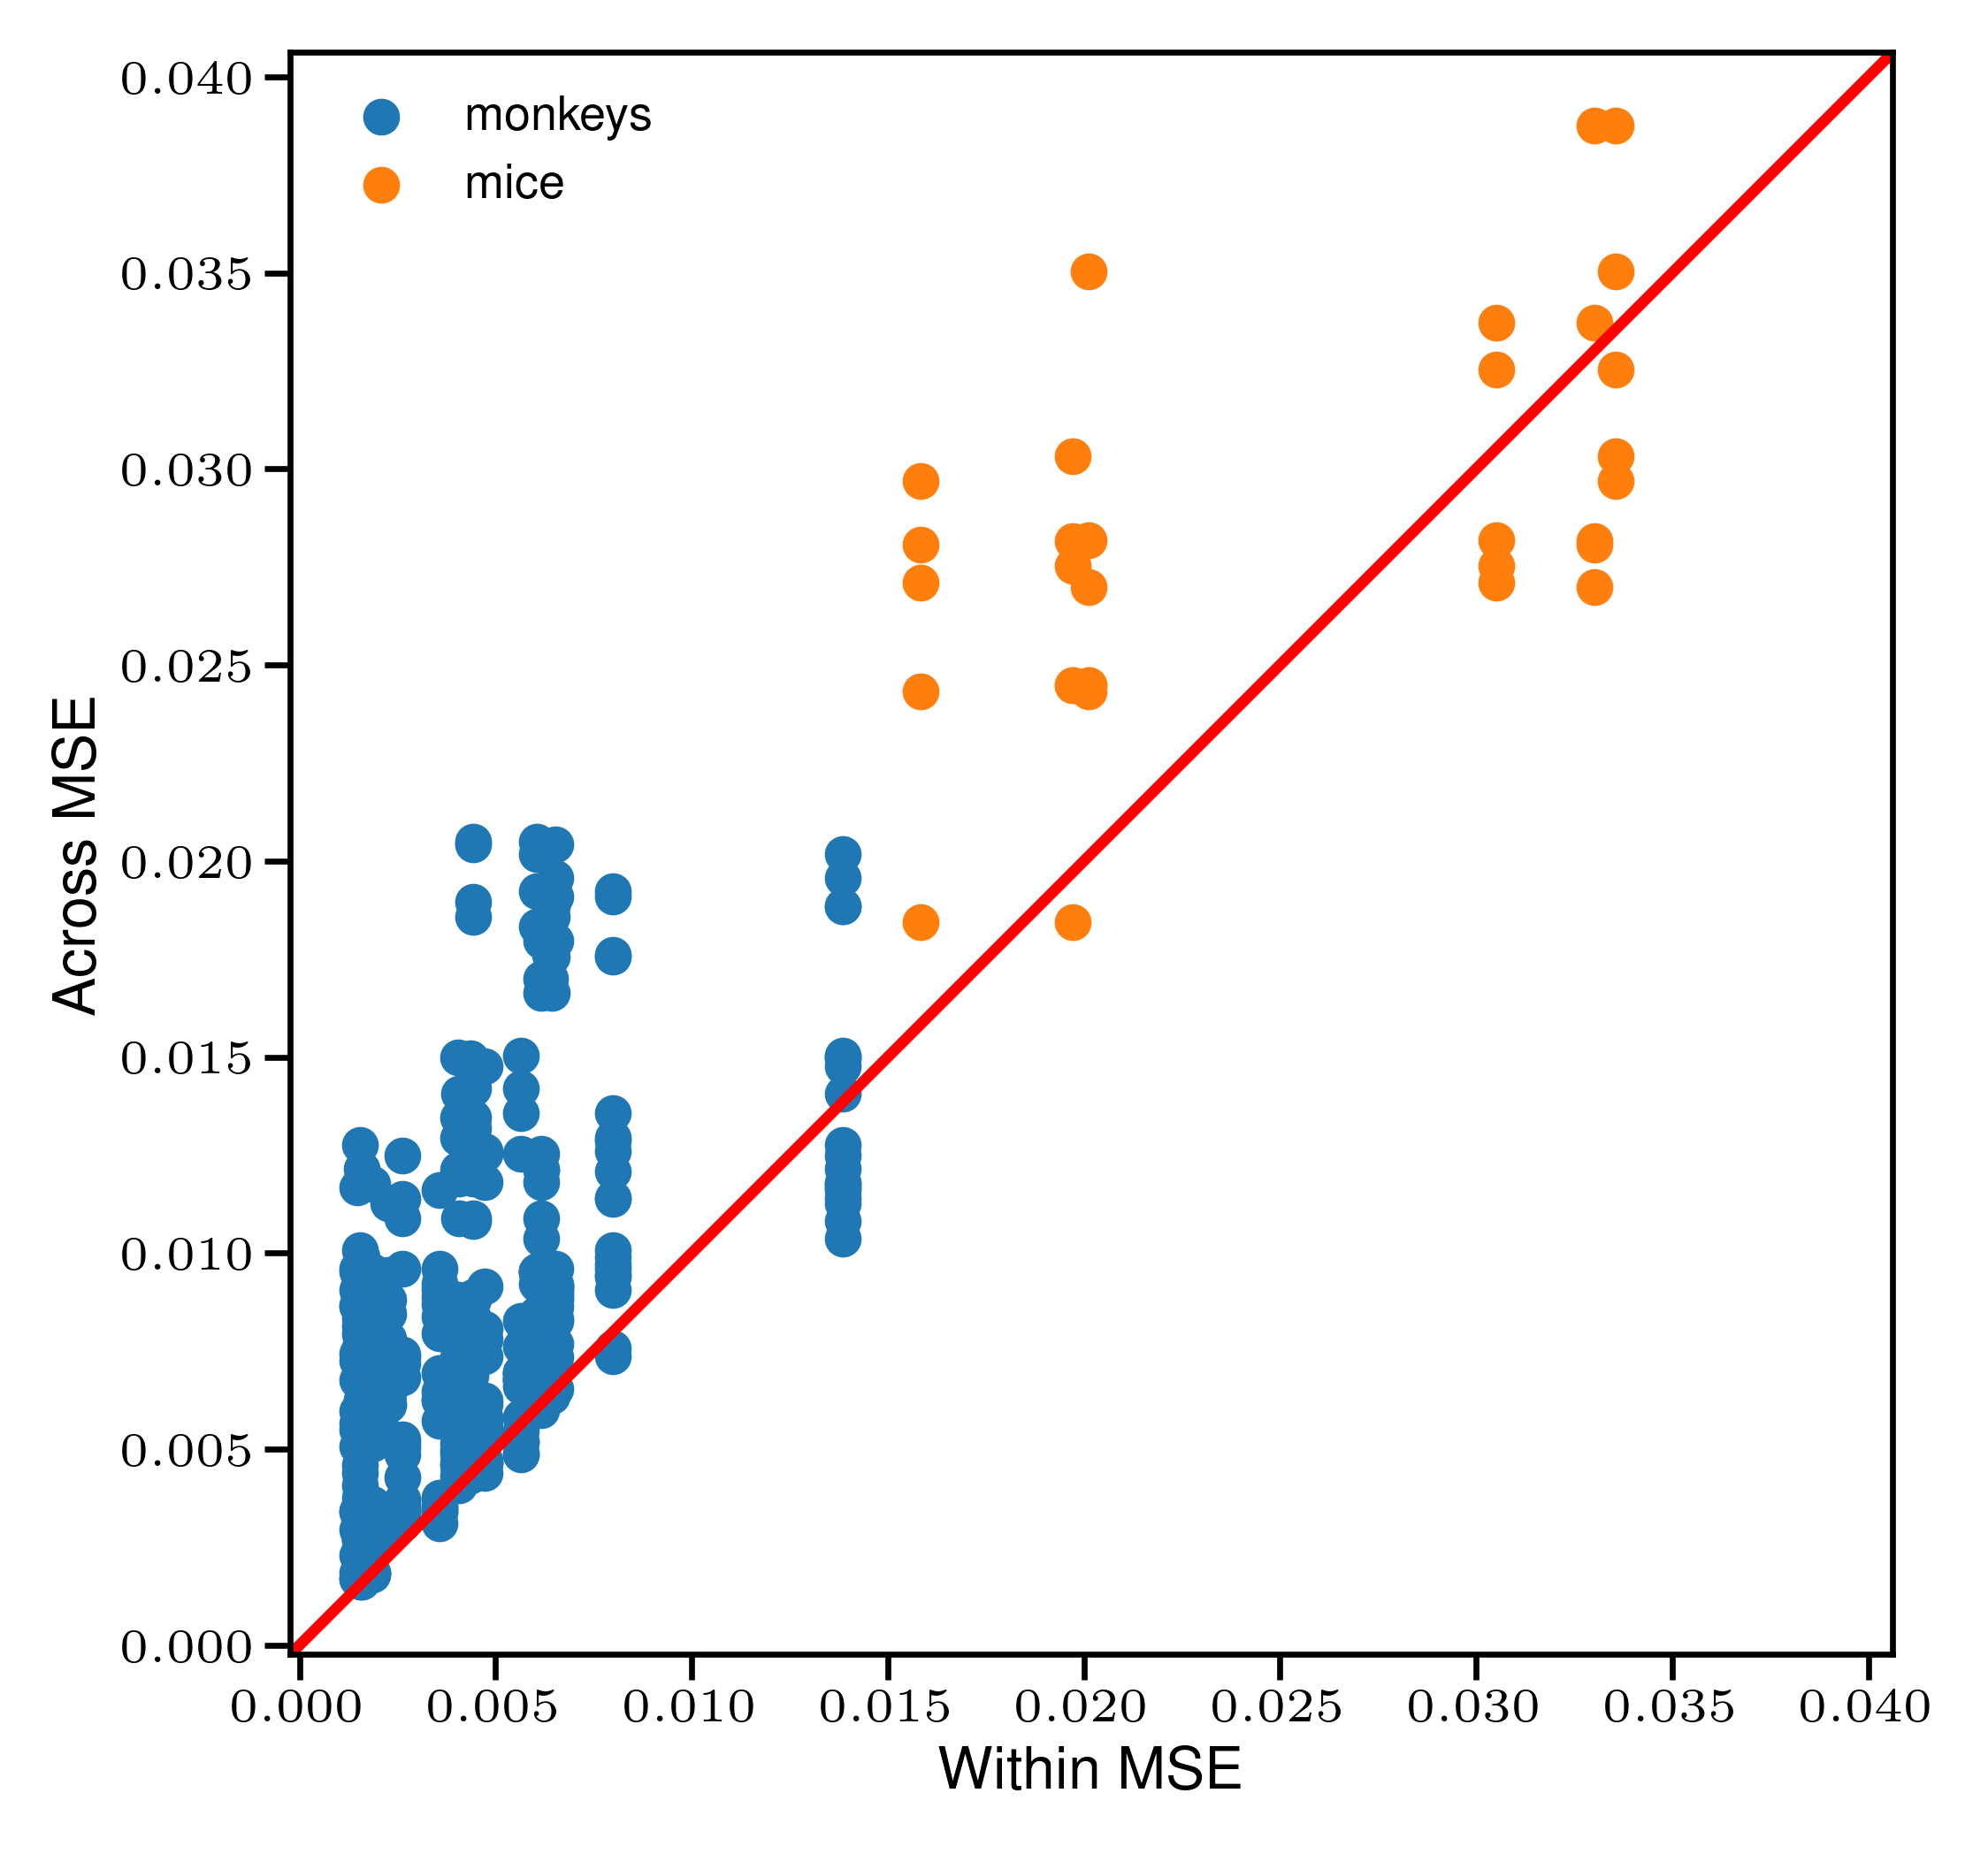

In [22]:
if "__file__" not in dir():     
    fig,ax = plt.subplots()
    ax.set_aspect(1)
    ax.scatter(monkey_w, monkey_a, label='monkeys')
    ax.scatter(mouse_w, mouse_a, label='mice')
    ax.legend()
    ax.axline([0, 0], [1, 1], color='r', transform = ax.transAxes)

    ax.set_xlabel('Within MSE')
    ax.set_ylabel('Across MSE')
    xmin, xmax, ymin, ymax = ax.axis()
    ax.axis([min(xmin,ymin), max(xmax,ymax), min(xmin,ymin), max(xmax,ymax)])

    fig.savefig(params.figPath / 'behav-MSE-scatter.pdf', format='pdf', bbox_inches='tight')

Plot distribution of Behavioural correlations

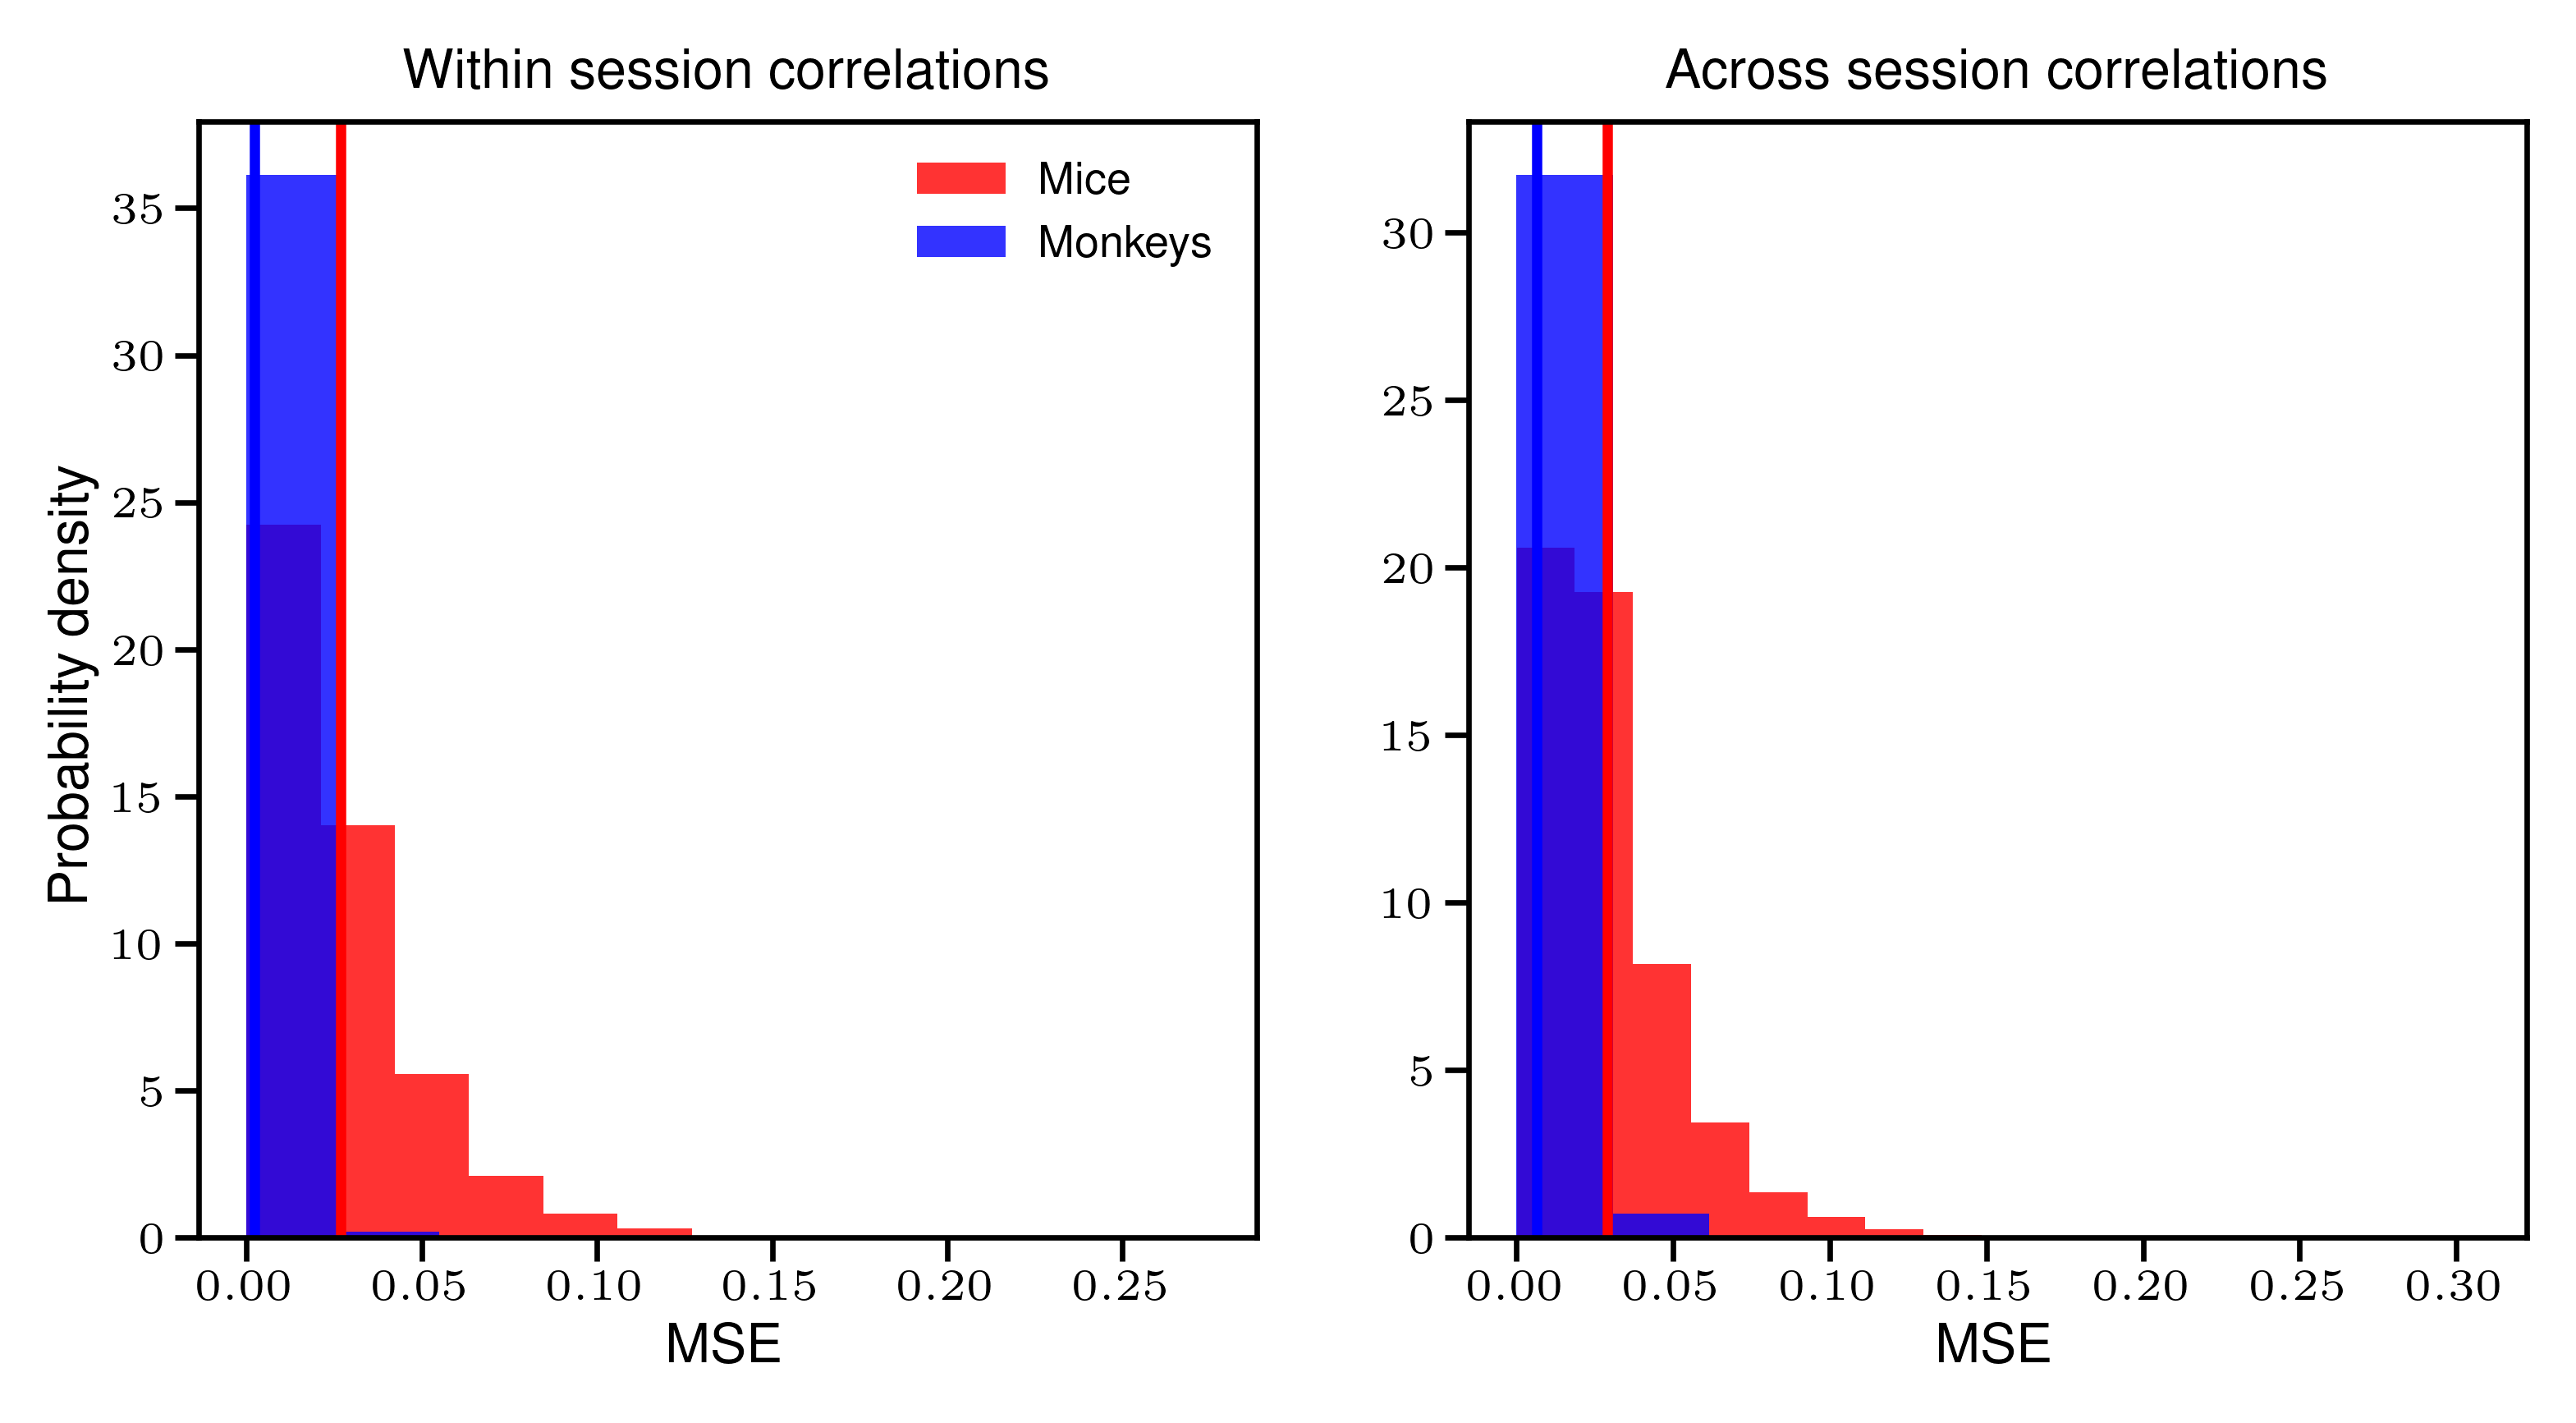

In [23]:
if "__file__" not in dir():     
    fig,axes = plt.subplots(1,2,figsize=(6.1,3))
    
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    axes[0].hist(w_mice,   density=True,alpha=.8,color='r',label=r'Mice')
    axes[0].hist(w_monkey, density=True,alpha=.8,color='b',label=r'Monkeys')
    axes[0].axvline(w_mice.mean(), color='r')
    axes[0].axvline(w_monkey.mean(), color='b')
    axes[0].set_title('Within session correlations')

    a_mice = np.array([m for L in across_corrs_mice.values() for l in L.values() for m in l])
    a_monkey = np.array([m for L in across_corrs_monkeys.values() for l in L.values() for m in l])
    axes[1].hist(a_mice, density=True, alpha=.8,color='r',label=r'Mice')
    axes[1].hist(a_monkey, density=True, alpha=.8,color='b',label=r'Monkeys')
    axes[1].axvline(a_mice.mean(), color='r')
    axes[1].axvline(a_monkey.mean(), color='b')
    axes[1].set_title('Across session correlations')
    

    axes[0].legend()
#     axes[0].set_ylabel(r"");
    
    for ax in axes:
        ax.set_xlabel(r"MSE");
    axes[0].set_ylabel('Probability density')
    


# Canonical Correlations

mice

In [24]:
pairFileList_mice = []
for I, df1 in enumerate(AllDFs):
    for J, (df2) in enumerate(AllDFs):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList_mice.append((I,J))


monkeys

In [25]:
pairFileList_monkeys = []
for I, df1 in enumerate(allDFs_MCx):
    for J, df2 in enumerate(allDFs_MCx):
        if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
        if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
        pairFileList_monkeys.append((I,J))

read data

In [26]:
side1df = [AllDFs[i] for i,_ in pairFileList_mice]
side2df = [AllDFs[j] for _,j in pairFileList_mice]
warnings.filterwarnings("ignore")
AllData1_mice = dt.get_data_array(side1df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
AllData2_mice = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
_,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

side1df = [allDFs_MCx[i] for i,_ in pairFileList_monkeys]
side2df = [allDFs_MCx[j] for _,j in pairFileList_monkeys]
AllData1_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
AllData2_monkey = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
_,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

warnings.filterwarnings("default")


In [27]:
CC_corr_mice=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
    data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
    k,l = pairFileList_mice[i]
    behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_mice.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_mice = np.array(CC_corr_mice)


CC_corr_monkey=[]
for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
    data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
    k,l = pairFileList_monkeys[i]
    behav = np.array(across_corrs_monkeys[allDFs_MCx[k].session[0]][allDFs_MCx[l].session[0]])
    # behav = behav[behav>params.Behav_corr_TH]
    CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
CC_corr_monkey = np.array(CC_corr_monkey)

plot

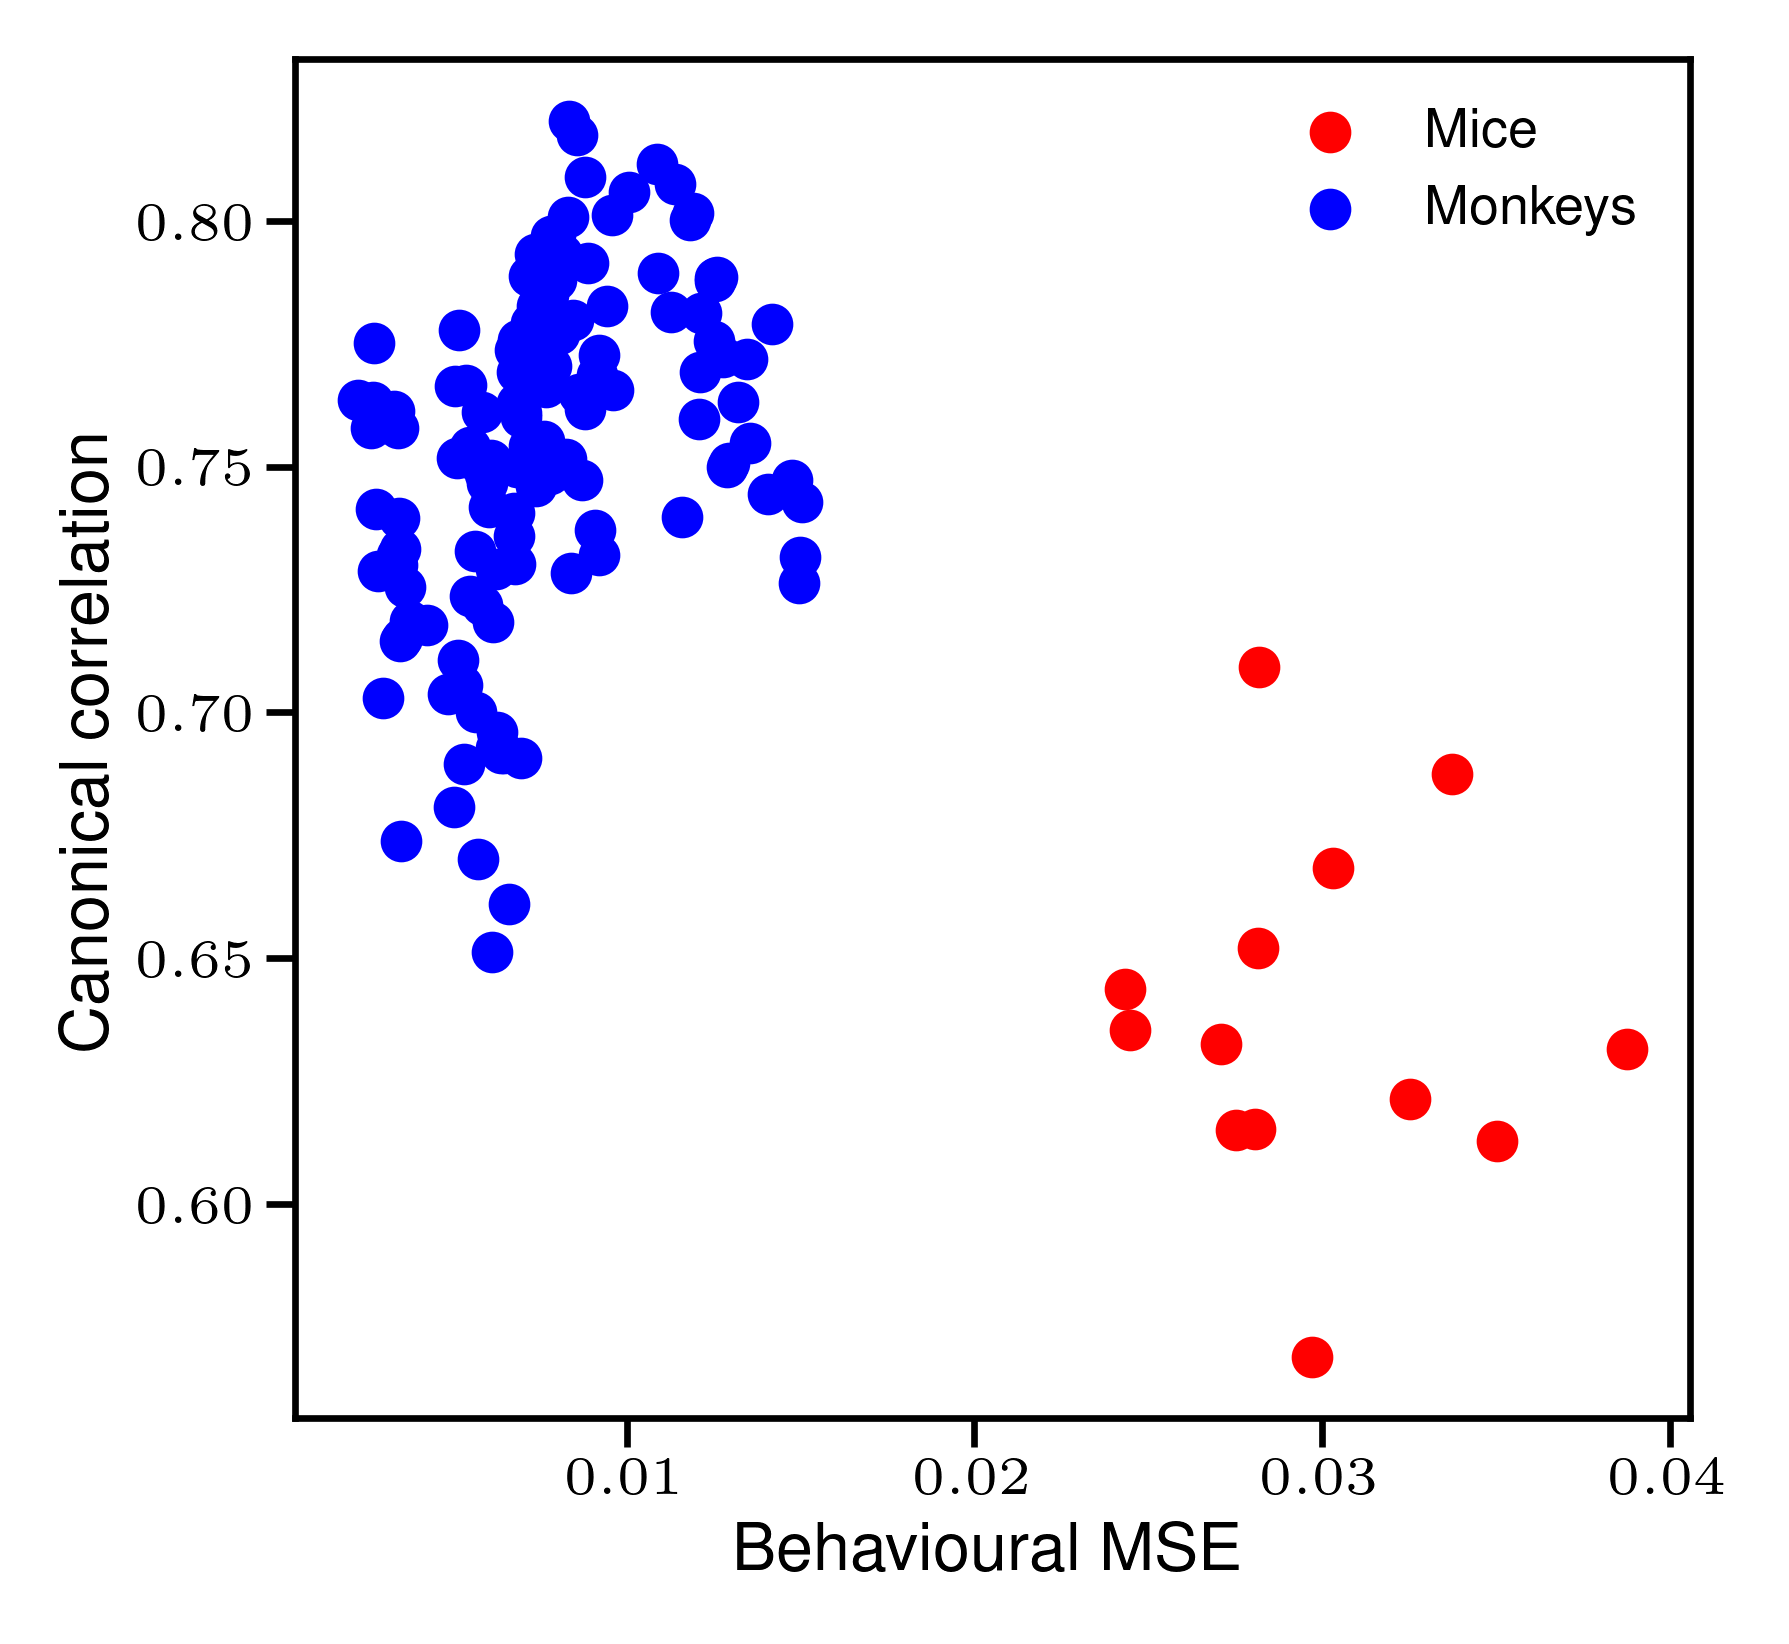

In [28]:
if "__file__" not in dir():     
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    
    ax.scatter(CC_corr_mice[:,1],CC_corr_mice[:,0],color='r', label='Mice', zorder=1)
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color='b', label='Monkeys', zorder=0)

    ax.set_xlabel('Behavioural MSE')
    ax.set_ylabel('Canonical correlation')
    ax.legend()
    
#     ax.set_title(f'min. behav. corr.: {Behav_corr_TH:0.2f}')
    
    fig.savefig(params.figPath / 'traj-canon-MSE.pdf', format='pdf', bbox_inches='tight')